## Dataset Link : 
https://drive.google.com/drive/folders/1s7LQEJag6MiHTUmE4Db-yA7pRg51J1YZ?usp=sharing

In [1]:
import os
import random
import shutil
import pickle

import numpy as np

import PIL

import matplotlib.pyplot as plt

import torchvision
import torchvision.utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler

from functorch import vmap
from functools import partial

from typing import Tuple, Iterable


In [2]:
### Helper Functions

# Showing images
def imshow(img, text=None):
    
    npimg = img.numpy()
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.axis("off")
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

    
def show_la_plot(loss_list,  accuracy_list):
    
    fig, ax1 = plt.subplots()

    # create a subplot for the current key
    # ax = fig.add_subplot(len(data1), 1, i+1)

    color = 'tab:green'
    ax1.set_xlabel('epoch',color=color)
    
    color = 'tab:red'
    ax1.plot(loss_list,color=color)
    ax1.set_ylabel('total loss',color=color)
    ax1.tick_params(axis='y', color=color)
        
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  
    ax2.plot( accuracy_list, color=color)
    ax2.tick_params(axis='y', color=color)

    ax1.set_title("loss vs acc")

    fig.tight_layout()

    
    # show the figure
    plt.show()
    
    
# visualizing one batch of data    
def visualize_images(pair_dataset, num_pairs):
    
    print("\n\nvisualising ", num_pairs, " data samples from the dataset\n")
    
    # Create a simple dataloader just for simple visualization
    vis_dataloader = DataLoader(pair_dataset, shuffle=True, batch_size=num_pairs)

    # Extract one batch
    example_batch = next(iter(vis_dataloader))

    concatenated = torch.cat((example_batch[0], example_batch[1]),0)

    imshow(torchvision.utils.make_grid(concatenated, nrow=num_pairs))
        
    
# computing the accuracy
def compute_accuracy(model, data_loader, sim_threshold):
    
    correct = 0
    total = 0

    for img_q, img_s, true_label, _ in data_loader:
        
#         true_label = torch.where(true_label > 1, torch.tensor([2]), true_label)
        
        similarity, logits = model(img_q, img_s)
        
        logits = torch.softmax(logits, dim=1)
        
        predicted_label = torch.argmax(logits, dim=-1)
        
        correct += (predicted_label == true_label).sum().item()
        total += true_label.size(0)
    
    accuracy = 100 * correct / total
    
    return accuracy


In [3]:
class PairDataset(Dataset):
    
    def __init__(self,dataset,transform=None,should_invert=True):
        self.dataset = dataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
                
        data0 = random.choice(self.dataset)

        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0, 1)
        
        if should_get_same_class:
            #keep looping till the same class image is found
            while True:
                data1 = random.choice(self.dataset)
                if data0[1] == data1[1]:
                    break
                    
        else:
            data1 = random.choice(self.dataset)

                    
        img0 = PIL.Image.fromarray(data0[0])
        img0_label = data0[1]
        
        img1 = PIL.Image.fromarray(data1[0])
        img1_label = data1[1]
            
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, img0_label, img1_label
        
    
    def __len__(self):
        return len(self.dataset)

In [4]:
class TripletDataset(Dataset):
    
    def __init__(self,dataset,transform=None,should_invert=True):
        self.dataset = dataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
                
        data0 = random.choice(self.dataset)
        
        #keep looping till the same class image is found
        while True:
            data1 = random.choice(self.dataset)
            if data0[1] == data1[1]:
                break
        
        #keep looping till a different class image is found
        while True:
            data2= random.choice(self.dataset)
            if data0[1] != data2[1]:
                break
       
                    
        img_anch = PIL.Image.fromarray(data0[0])
        img_pos = PIL.Image.fromarray(data1[0])
        img_neg = PIL.Image.fromarray(data2[0])
            
        if self.should_invert:
            img_anch = PIL.ImageOps.invert(img_anch)
            img_pos = PIL.ImageOps.invert(img_pos)
            img_neg = PIL.ImageOps.invert(img_neg)

        if self.transform is not None:
            img_anch = self.transform(img_anch)
            img_pos = self.transform(img_pos)
            img_neg = self.transform(img_neg)

        img_anch_label = data0[1]
        
        return img_anch, img_pos, img_neg, img_anch_label
        
    
    def __len__(self):
        return len(self.dataset)

In [5]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=0.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, similarity, label):
        
        loss_contrastive = torch.mean((1-label) * torch.pow(similarity, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - similarity, min=0.0), 2))
        
        return loss_contrastive
    

In [6]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, similarity_pos, similarity_neg):
        
        losses = torch.relu(similarity_pos - similarity_neg + self.margin)
        
        return losses.mean()

In [7]:
class SiameseNetwork(nn.Module):
    def __init__(self, cnn_layers: Iterable, linear_layers, out_channels: int):
        super().__init__()
        
        # pass in a NN
        self.cnn_layers = nn.Sequential(*cnn_layers)
        self.linear_layers = nn.Sequential(*linear_layers)
        
        
        # p can be change to induced norm (i.e., p = 1, p = 2)
        self.norm_fn = vmap(
            partial(torch.norm, p = 'fro')
        )
        
        #final linear layer to get prediction representation
        self.predictor = vmap(nn.Linear(1, out_channels))
        
        
    
    def forward(self, x_query: torch.Tensor, x_support: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward Pass:
            arg: Query Image (any image)
                 Support Image
        
        """
                
        x_query = self.cnn_layers(x_query)        
        x_support = self.cnn_layers(x_support)
        
#         similarity = vmap(F.pairwise_distance)(x_query, x_support)[:, None]        
        similarity = (self.norm_fn(x_query - x_support) + 1e-8)[:, None]

        logits = self.linear_layers(x_query.view(x_query.size()[0], -1))
            
        return similarity, logits


In [8]:
class ELM(nn.Module):
    def __init__(self, n_input, n_output, activation_function=torch.sigmoid):
        super(ELM, self).__init__()
        self.n_input = n_input
        self.n_output = n_output
        self.activation_function = activation_function
        self.register_buffer('bias', torch.randn(n_output))
        self.register_buffer('input_weights', torch.randn(n_input, n_output))

    def forward(self, input):
        input = input.view(input.size(0), -1)
        output = torch.matmul(input, self.input_weights)
        output.add_(self.bias)
        if self.activation_function is not None:
            output = self.activation_function(output)
        return output

# class ELMMixture(nn.Module):
#     def __init__(self, n_input, n_output, n_elms):
#         super(ELMMixture, self).__init__()
#         self.elms = nn.ModuleList([ELM(n_input, n_output) for _ in range(n_elms)])

#     def forward(self, x):
#         output = torch.zeros((x.shape[0], self.elms[0].n_output), dtype=torch.float32)
#         for elm in self.elms:
#             output.add_(elm(x))
#         return output


# cnn_layers = [
    
#     nn.Conv2d(3, 16, kernel_size=3, padding=1),
#     nn.BatchNorm2d(16),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2, stride=2),
    
#     nn.Conv2d(16, 32, kernel_size=3, padding=1),
#     nn.BatchNorm2d(32),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2, stride=2),

#     nn.Conv2d(32, 64, kernel_size=3, padding=1),
#     nn.BatchNorm2d(64),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2, stride=2),
    
#     nn.Conv2d(64, 128, kernel_size=3, padding=1),
#     nn.BatchNorm2d(128),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2, stride=2),
# ]

# linear_layers = [
  
#     ELMMixture(128, 3, n_elms=7)

# #     nn.Linear(576, 1000),
# #     nn.ReLU(),
    
# # #     nn.Linear(128, 3)
# #     ELMMixture(1000, 100, n_elms=5),
# #     ELMMixture(100, 3, n_elms=5)
# ]


# # linear_layers = [
  
# #     nn.Linear(576, 128),
# #     nn.ReLU(),
    
# # #     nn.Linear(128, 3)
# #     ELMMixture(128, 3, n_elms=5)
# # ]

cnn_layers = [
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
#     nn.Conv2d(64, 128, kernel_size=3, padding=1),
#     nn.BatchNorm2d(128),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2, stride=2),
]

linear_layers = [
    
    ELM(576, 256),
    ELM(256, 128),
    ELM(128, 3)
    
]


model = SiameseNetwork(cnn_layers, linear_layers, 3)

In [9]:
# Hyperparametes 

batch_size = 32
learning_rate = 0.01


In [10]:
# Loading the data

root = "datasets_for_comparison"

with open(root+'/vehicles_in_accidents_train.pkl', 'rb') as f:
    accident_train_data = pickle.load(f)
with open(root+'/vehicles_in_accidents_validation.pkl', 'rb') as f:
    accident_validation_data = pickle.load(f)
with open(root+'/vehicles_in_accidents_test.pkl', 'rb') as f:
    accident_test_data = pickle.load(f)
    
print("Accident Train Data Size       = ", len(accident_train_data))
print("Accident Validation Data Size  = ", len(accident_validation_data))
print("Accident Test Data Size  = ", len(accident_test_data))


Accident Train Data Size       =  1580
Accident Validation Data Size  =  526
Accident Test Data Size  =  530




visualising  10  data samples from the dataset



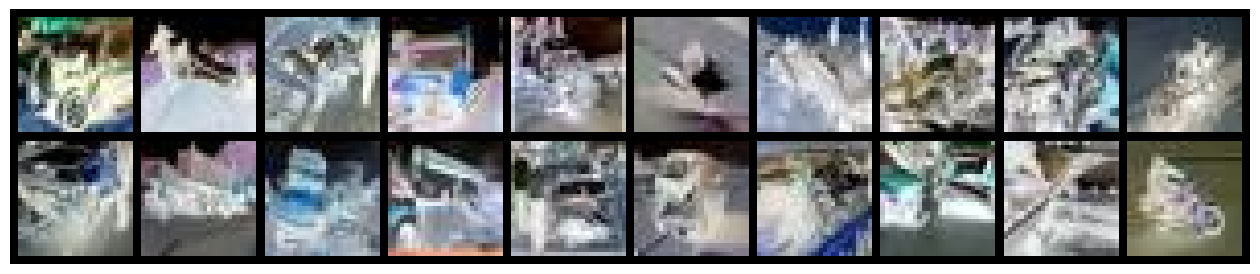



Batch Size    =  32
Train Batches =  50
Validation Batches  =  17




In [11]:

## Loading Data


transformation = transforms.Compose([transforms.Resize((28, 28)),
                                     transforms.ToTensor()
                                    ])


# Load the training dataset

train_dataset = TripletDataset(accident_train_data, transform=transformation)
validation_dataset = PairDataset(accident_validation_data, transform=transformation)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
validation_loader = DataLoader(validation_dataset, shuffle=True, batch_size=batch_size)

visualize_images(validation_dataset, num_pairs=10)

print("\n")
print("Batch Size    = ", batch_size)
print("Train Batches = ", len(train_loader))
print("Validation Batches  = ", len(validation_loader))
print("\n")


In [12]:
# Training

criterion1 = ContrastiveLoss(margin=1)
criterion2 = nn.CrossEntropyLoss()
criterion3 = TripletLoss(margin=1)

global_max_acc = -1
best_lr = -1


optimizer = optim.AdamW(model.parameters(), lr = learning_rate, weight_decay=0.01)

counter = []
loss_history = [] 
acc_history = [] 

tot_iteration= 0

mx_acc = -1

for epoch in range(50):

    tot_loss = 0

    for i, (img_a, img_p, img_n, q_label) in enumerate(train_loader, 0):

        optimizer.zero_grad()

        similarity_p, logits_a = model.forward(img_a, img_p)
        similarity_n, logits_a = model.forward(img_a, img_n)

#         q_label = torch.where(q_label > 1, torch.tensor([2]), q_label)

        loss = criterion3(similarity_p, similarity_n) + criterion2(logits_a, q_label)

        tot_loss += loss.item()

        loss.backward()

        optimizer.step()

#         if(tot_iteration%50 == 0):
#             print(f"Loss = {loss.item():.5f}")

        tot_iteration += 1


    tot_loss /= len(train_loader)
    accuracy = compute_accuracy(model, validation_loader, sim_threshold=1)

    if(accuracy > mx_acc):
        mx_acc = accuracy
        torch.save(model.state_dict(), 'vehicle_best_model.pth')
    
    loss_history.append(tot_loss)
    acc_history.append(accuracy)

    print(f"Epoch {epoch} :: Curr Loss = {tot_loss:.5f}  :: Curr Acc = {accuracy:.5f}")



Epoch 0 :: Curr Loss = 2.19240  :: Curr Acc = 54.94297
Epoch 1 :: Curr Loss = 1.78939  :: Curr Acc = 53.04183
Epoch 2 :: Curr Loss = 1.71072  :: Curr Acc = 58.93536
Epoch 3 :: Curr Loss = 1.69045  :: Curr Acc = 61.02662
Epoch 4 :: Curr Loss = 1.56481  :: Curr Acc = 61.97719
Epoch 5 :: Curr Loss = 1.49784  :: Curr Acc = 67.30038
Epoch 6 :: Curr Loss = 1.46941  :: Curr Acc = 66.34981
Epoch 7 :: Curr Loss = 1.46440  :: Curr Acc = 63.68821
Epoch 8 :: Curr Loss = 1.49072  :: Curr Acc = 67.11027
Epoch 9 :: Curr Loss = 1.49108  :: Curr Acc = 61.21673
Epoch 10 :: Curr Loss = 1.43657  :: Curr Acc = 69.58175
Epoch 11 :: Curr Loss = 1.38902  :: Curr Acc = 74.90494
Epoch 12 :: Curr Loss = 1.34304  :: Curr Acc = 72.43346
Epoch 13 :: Curr Loss = 1.28620  :: Curr Acc = 68.63118
Epoch 14 :: Curr Loss = 1.32086  :: Curr Acc = 71.67300
Epoch 15 :: Curr Loss = 1.27761  :: Curr Acc = 73.76426
Epoch 16 :: Curr Loss = 1.29590  :: Curr Acc = 76.61597
Epoch 17 :: Curr Loss = 1.19357  :: Curr Acc = 71.86312
Ep

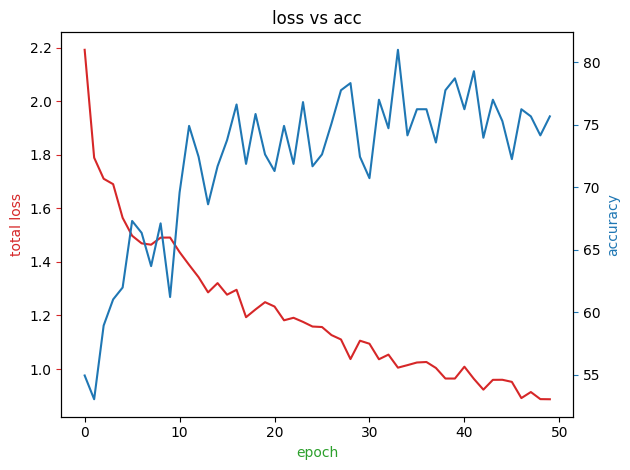

In [13]:
show_la_plot(loss_history, acc_history)

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

test_dataset = PairDataset(accident_test_data, transform=transformation)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

model.load_state_dict(torch.load('vehicle_best_model.pth'))

true_labels = []
predicted_labels = []

for img_q, img_s, true_label, _ in test_loader:
        
#         true_label = torch.where(true_label > 1, torch.tensor([2]), true_label)
        
        similarity, logits = model(img_q, img_s)
        
        logits = torch.softmax(logits, dim=1)
        
        predicted_label = torch.argmax(logits, dim=-1)
        
        true_labels.extend(true_label.numpy())
        predicted_labels.extend(predicted_label.numpy())


precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')
accuracy = accuracy_score(true_labels, predicted_labels)

print("\nOn Test Data\n")
print("Precision : ", precision)
print("Recall    : ", recall)
print("F1-score  : ", f1)
print("Accuracy  : ", accuracy)
print("\n\n")


On Test Data

Precision :  0.8139975814622348
Recall    :  0.7989089130469865
F1-score  :  0.8014408448399225
Accuracy  :  0.8075471698113208



